### NLP Analysis

#### Importing Required Libraries

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import MDS, TSNE
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


#### Importing the Dataset

In [2]:
df = pd.read_csv('data/reddit_parenting_combined.csv') 
df.dropna(inplace=True, subset=['selftext_clean'])

In [3]:
df.sample(2)

,ID,title,author,created_time,url,score,permalink,subreddit,selftext,num_comments,is_self,link_flair_text,link_flair_css_class,upvote_ratio,over_18_content,tag,selftext_clean,title_clean
3016,18ymhok,"RANT: Son ""hopes he dies"" b/c grandmother is f...",leeretaschen,2024-01-04 20:05:52+00:00,https://www.reddit.com/r/atheistparents/commen...,55,/r/atheistparents/comments/18ymhok/rant_son_ho...,atheistparents,My in-laws (especially my mother-in-law) are v...,14,True,NaN,NaN,0.98,False,NaN,inlaws especially motherinlaw religious wife a...,rant son hopes dies bc grandmother filling hea...
1666,18dy1au,9yo got in trouble at school,eddles08,2023-12-08 22:07:25+00:00,https://www.reddit.com/r/atheistparents/commen...,19,/r/atheistparents/comments/18dy1au/9yo_got_in_...,atheistparents,I received an email from my son’s teacher righ...,13,True,NaN,NaN,0.95,False,NaN,received email sons teacher right school let n...,yo got trouble school


In [4]:
df.subreddit.value_counts()

subreddit
Parenting            2992
atheistparents       2322
MuslimParenting       766
CatholicParenting     696
Name: count, dtype: int64

In [7]:
sampled_data = pd.concat(
    [df[df['subreddit'] == subreddit].sample(n=650, random_state=1)
      for subreddit in df.subreddit.unique()]
)

In [8]:
sampled_data.subreddit.value_counts()

subreddit
CatholicParenting    650
atheistparents       650
MuslimParenting      650
Parenting            650
Name: count, dtype: int64

### Generating TFID Vectors

In [9]:
def generate_tfidf_matrix(texts, max_terms=50, min_doc_freq=2):
    """
    Generate TF-IDF matrix and feature names from texts.
    """

    vectorizer = TfidfVectorizer(
        stop_words=stopwords.words('english'),
        max_features=max_terms,
        min_df=min_doc_freq
    )
    
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    
    return tfidf_matrix, feature_names

In [10]:
tfidf_matrix, feature_names = generate_tfidf_matrix(sampled_data.selftext.values)

In [11]:
tfid_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfid_df.head(5)


,also,baby,child,children,could,daughter,day,even,family,feel,...,things,think,time,told,us,want,way,wife,would,year
0,0.0,0.0,0.000000,0.667745,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.341648,0.000000,0.0,0.0,0.282575,0.000000
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.756882,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.653552
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.225832,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.282935,0.000000,0.0,0.0,0.000000,0.0,0.280186,0.0,...,0.0,0.278644,0.0,0.0,0.000000,0.235269,0.0,0.0,0.000000,0.000000


### T-SNE Plots
**Using Bernie's Code**

In [12]:
def plot_word_similarities_tsne(tfidf_matrix, feature_names, n_highlight=10, perplexity=30, title=None):
    """
    Plot word similarities using t-SNE with all terms but highlighting top N.
    """
    # Get vectors for all terms
    term_vectors = tfidf_matrix.T.toarray()
    
    # Identify top terms
    mean_tfidf = tfidf_matrix.mean(axis=0).A1
    top_indices = mean_tfidf.argsort()[-n_highlight:][::-1]
    top_terms = feature_names[top_indices]
    
    # Calculate t-SNE for all terms
    tsne = TSNE(n_components=2, 
                perplexity=min(30, len(feature_names)/4), 
                random_state=42)
    coords = tsne.fit_transform(term_vectors)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot all points in light gray
    ax.scatter(coords[:, 0], coords[:, 1], 
              c='lightgray', alpha=0.5, s=30)
    
    # Highlight top terms
    ax.scatter(coords[top_indices, 0], coords[top_indices, 1], 
              c='red', s=100)
    
    # Add labels for top terms
    for i, term in enumerate(top_terms):
        ax.annotate(term, 
                   (coords[top_indices[i], 0], coords[top_indices[i], 1]),
                   fontsize=14,
                   bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7)
        )
    if title:
        ax.set_title(f'Word Similarities in {title} (Top {n_highlight} Terms Highlighted)')
    else:
        ax.set_title(f'Word Similarities (Top {n_highlight} Terms Highlighted)')
    plt.tight_layout()
    return fig, ax

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'center': 'Word Similarities in Reddit Parenting (Top 10 Terms Highlighted)'}>)

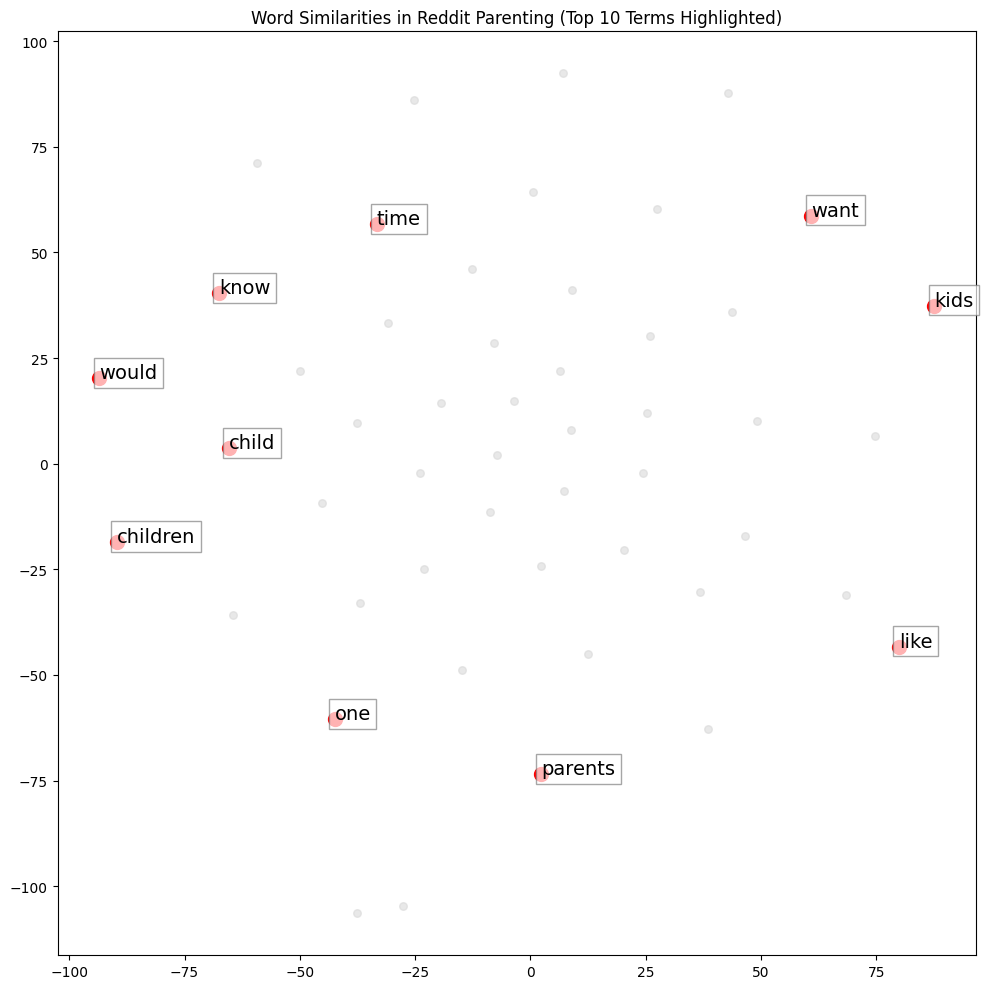

In [13]:
plot_word_similarities_tsne(tfidf_matrix, feature_names, title='Reddit Parenting')

In [14]:
def split_label(label, max_line_length=25, max_lines=2):
    """Split label at the nearest space before max_line_length and return max_lines"""
    lines = []
    temp_label = label
    
    while len(temp_label) > max_line_length:
        split_index = temp_label.rfind(' ', 0, max_line_length)
        if split_index == -1:
            split_index = max_line_length
        lines.append(temp_label[:split_index])
        temp_label = temp_label[split_index:].strip()
        
    lines.append(temp_label)
    
    return '\n'.join(lines[:max_lines])

def plot_similarities(tfidf_matrix, labels, 
                      title="term document plot", 
                        method='tsne', is_documents=True, label_color=False,
                      top_terms=None, figsize=(12, 8)):
    """
    Create projection visualization of document or term similarities
    
    Parameters:
    - tfidf_matrix: scipy sparse matrix
    - labels: list of labels (document texts or terms)
    - title: plot title
    - method: 'tsne' or 'mds' for dimensionality reduction
    - top_terms: if int, only annotate top n terms
    - is_documents: if True, plot documents, else plot terms
    - figsize: tuple for figure size
    """

    # Convert to dense array and transpose if visualizing terms
    matrix = tfidf_matrix.toarray()
    if not is_documents:
        matrix = matrix.T
    
    # Dimensionality reduction method
    if method == 'tsne':
        tsne = TSNE(n_components=2, 
                    perplexity=min(30, len(labels)-1),
                    random_state=42)
        coords = tsne.fit_transform(matrix)
    elif method == 'mds':
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        distances = 1 - cosine_similarity(matrix)
        coords = mds.fit_transform(distances)
    else:
        raise ValueError("Method must be 'tsne' or 'mds'") 
    
    # Create visualization
    fig, ax = plt.subplots(figsize=figsize)
    scatter = ax.scatter(coords[:, 0], coords[:, 1], alpha=0.6)
    
    # Add labels
    if top_terms and isinstance(top_terms, int):
        mean_tfidf = tfidf_matrix.mean(axis=0).A1 if is_documents else tfidf_matrix.mean(axis=1).A1
        top_indices = mean_tfidf.argsort()[-top_terms:][::-1]
        labels_to_annotate = [labels[i] for i in top_indices]
        coords_to_annotate = coords[top_indices]
    else:
        labels_to_annotate = labels
        coords_to_annotate = coords

    if label_color:
        unique_labels = list(set(labels_to_annotate))
        color_map = {label: color for label, color in zip(unique_labels, plt.cm.rainbow(np.linspace(0, 1, len(unique_labels))))}
        colors = [color_map[label] for label in labels_to_annotate]
    else:
        colors = ['black'] * len(labels_to_annotate)
    
    for i, (label, color) in enumerate(zip(labels_to_annotate, colors)):
        # Split long labels for documents
        if is_documents:
            label = split_label(label, 20)
            
        ax.annotate(label, (coords_to_annotate[i, 0], coords_to_annotate[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8 if is_documents else 12, alpha=0.7, color=color)
    
    
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.3)
    return fig, ax

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'Reddit Parenting'}>)

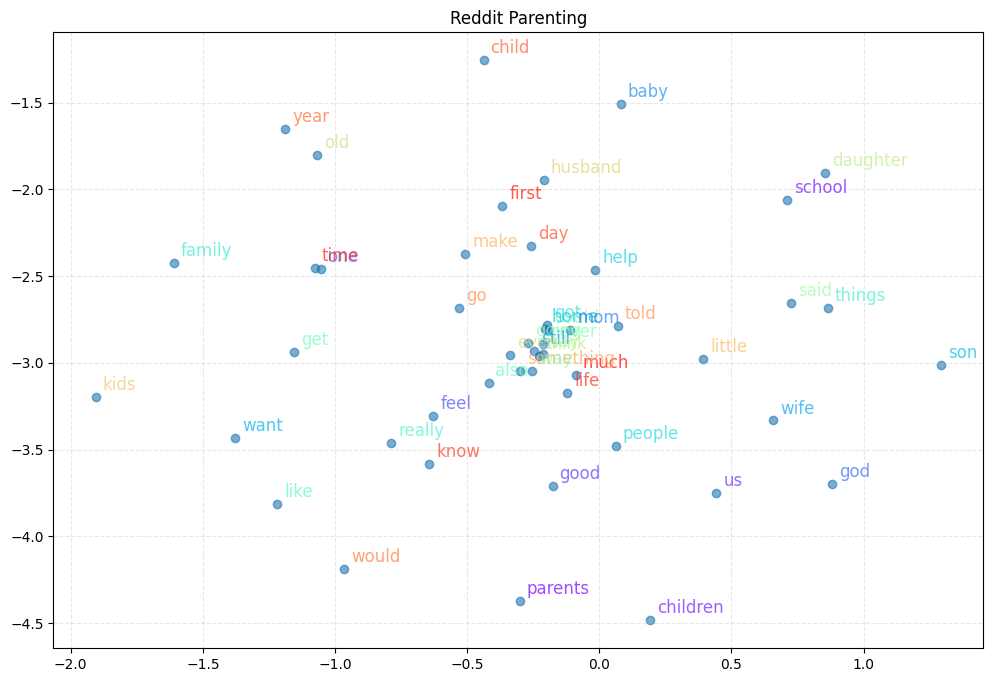

In [15]:
plot_similarities(tfidf_matrix, feature_names, title='Reddit Parenting', label_color=True, is_documents=False)

## NBC (Naive Bayes Classifier)

In [17]:
sampled_data.selftext_clean.isna().sum()

np.int64(0)

In [18]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(sampled_data.selftext_clean)
y = sampled_data.subreddit

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
print(X_train.shape, X_test.shape) 

(2080, 14520) (520, 14520)


In [22]:
# Naive Bayes Classification
nbc = MultinomialNB()
nbc.fit(X_train, y_train)
nbc_pred = nbc.predict(X_test)

# Analyze results
print("Naive Bayes Classification Results:")
print(classification_report(y_test, nbc_pred))

Naive Bayes Classification Results:
                   precision    recall  f1-score   support

CatholicParenting       0.95      0.97      0.96       125
  MuslimParenting       0.98      0.79      0.88       130
        Parenting       0.75      0.95      0.84       129
   atheistparents       0.96      0.88      0.92       136

         accuracy                           0.90       520
        macro avg       0.91      0.90      0.90       520
     weighted avg       0.91      0.90      0.90       520



## k-Means Clustering

In [53]:
# Vectorize `selftext_clean` using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=50)  # Adjust max_features if needed
tfidf_matrix = tfidf_vectorizer.fit_transform(sampled_data['selftext_clean'])

In [54]:
pd.DataFrame(tfidf_matrix.toarray())

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000000,0.000000,0.000000,0.674798,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.336477,0.000000,0.000000,0.0,0.279829,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.676559,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.588903
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.268283,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,0.000000,0.000000,0.267178,0.000000,0.000000,0.000000,0.0,0.289191,0.200969,0.0,...,0.0,0.258854,0.000000,0.0,0.000000,0.218680,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595,0.000000,0.000000,0.000000,0.000000,0.610180,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2596,0.258158,0.000000,0.557185,0.269728,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.232258,0.0,0.268991,0.000000,0.000000,0.0,0.000000,0.000000
2597,0.000000,0.488292,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.317696,0.000000
2598,0.084761,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.099007,0.137607,0.0,...,0.0,0.088621,0.381288,0.0,0.000000,0.224601,0.094069,0.0,0.000000,0.000000


### Elbow Plot

In [ ]:
# Lists to store inertia and silhouette scores for different values of k
inertia_values = []
silhouette_scores = []
k_values = range(2, 11)  # Testing k values from 2 to 10

# Loop over different values of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(tfidf_matrix)
    
    # Append inertia and silhouette scores
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(tfidf_matrix, clusters))


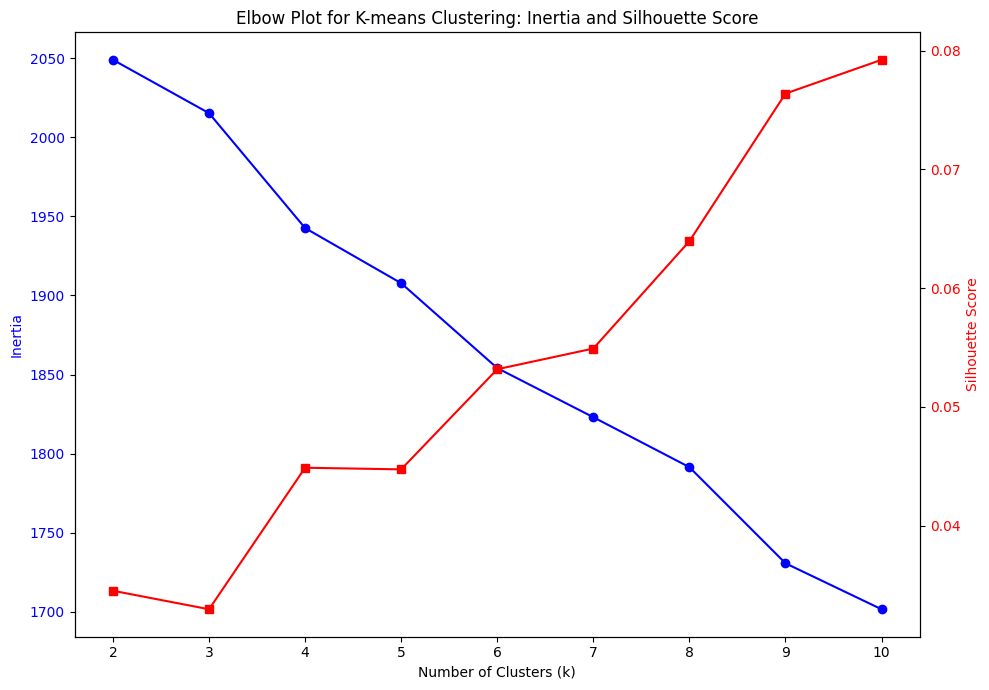

In [56]:
fig, ax1 = plt.subplots(figsize=(10, 7))

# Plot inertia on the primary y-axis
ax1.plot(k_values, inertia_values, 'b-o', label="Inertia")
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis to plot the silhouette score
ax2 = ax1.twinx()
ax2.plot(k_values, silhouette_scores, 'r-s', label="Silhouette Score")
ax2.set_ylabel("Silhouette Score", color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and legend
plt.title("Elbow Plot for K-means Clustering: Inertia and Silhouette Score")
fig.tight_layout()
plt.show()


In [ ]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(tfidf_matrix)

### PCA Representation

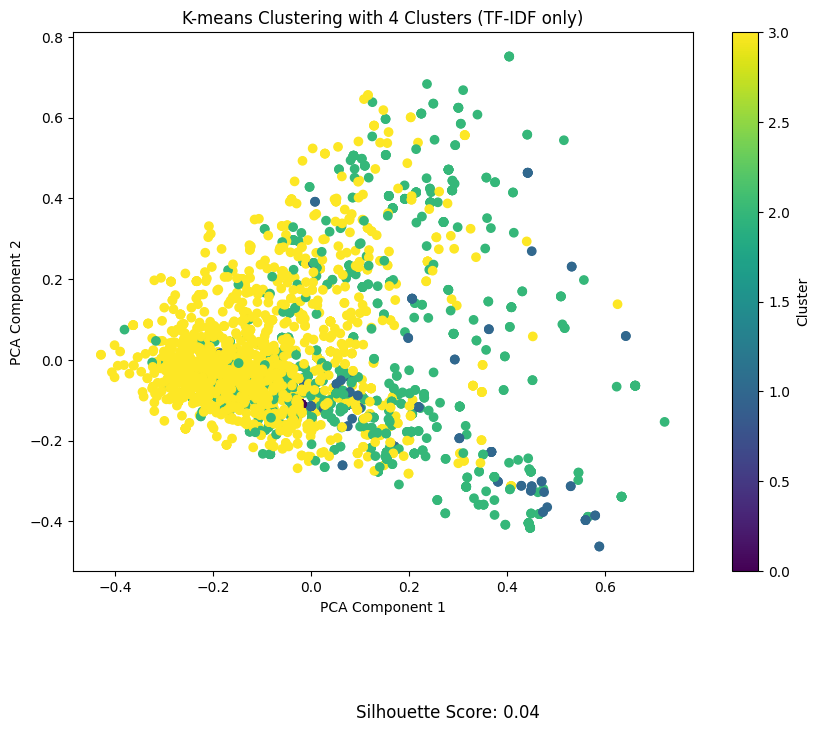

In [ ]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())

# Plot clusters
plt.figure(figsize=(10, 7))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=sampled_data['cluster'], cmap='viridis', marker='o')
plt.title("K-means Clustering with 4 Clusters (TF-IDF only)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")

# Calculate silhouette score
silhouette_avg = silhouette_score(tfidf_matrix, clusters)
plt.figtext(0.5, -0.1, f"Silhouette Score: {silhouette_avg:.2f}", ha="center", fontsize=12)

plt.show()

### TSNE Representation

/home/shreyansh-padaarha/Documents/GitHub/parenting-style-subreddits-analyser/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


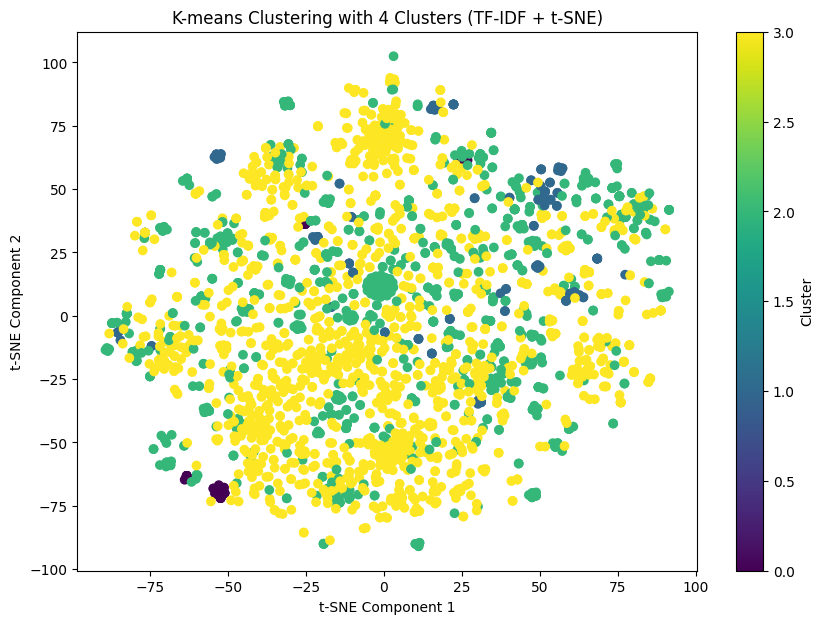

In [67]:
# Reduce dimensions for visualization with t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
reduced_data = tsne.fit_transform(tfidf_matrix.toarray())

# Plot clusters
plt.figure(figsize=(10, 7))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=sampled_data['cluster'], cmap='viridis', marker='o')
plt.title("K-means Clustering with 4 Clusters (TF-IDF + t-SNE)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label="Cluster")

/home/shreyansh-padaarha/Documents/GitHub/parenting-style-subreddits-analyser/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/shreyansh-padaarha/Documents/GitHub/parenting-style-subreddits-analyser/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/tmp/ipykernel_78758/157218392.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', 4)  # Using 'Set1' colormap for 4 distinct colors


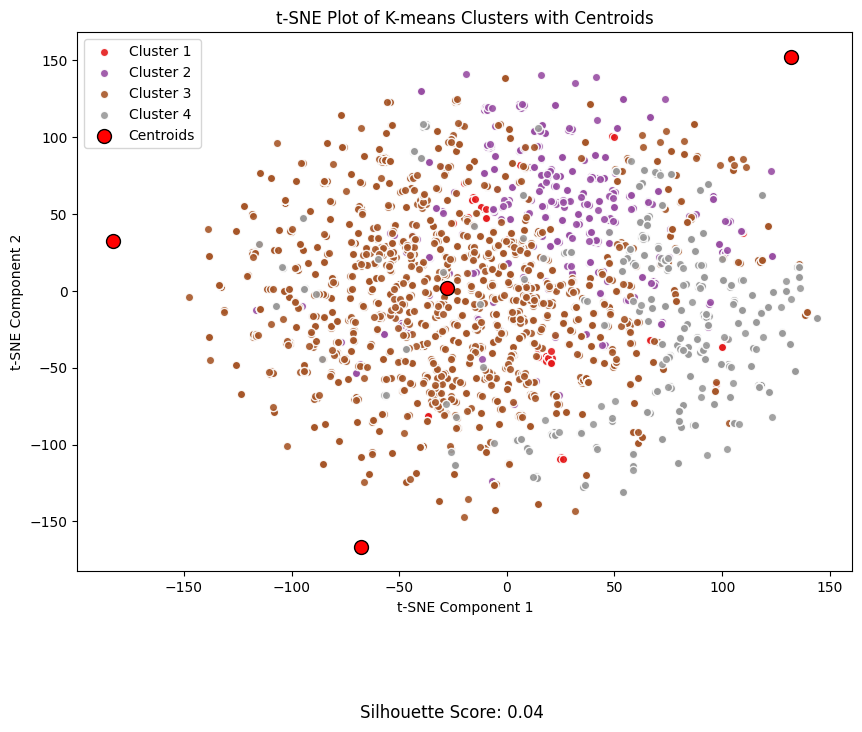

In [74]:
# Reduce dimensionality for visualization with t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=3, n_iter=1000)
reduced_data = tsne.fit_transform(tfidf_matrix.toarray())

# Apply t-SNE with lower perplexity for centroids
tsne_centroids = TSNE(n_components=2, random_state=0, perplexity=2, n_iter=1000)
centroids_2d = tsne_centroids.fit_transform(kmeans.cluster_centers_)

# Define unique colors for each cluster
colors = cm.get_cmap('Set1', 4)  # Using 'Set1' colormap for 4 distinct colors

# Plot data points with unique colors for each cluster
plt.figure(figsize=(10, 7))
for i in range(4):  # Assuming 4 clusters
    plt.scatter(
        reduced_data[clusters == i, 0],
        reduced_data[clusters == i, 1],
        color=colors(i),
        label=f'Cluster {i+1}',
        alpha=0.9,
        edgecolors='w'
    )

# Plot centroids with red circles and labels
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='red', s=100, edgecolor='black', marker='o', label='Centroids')
plt.title("t-SNE Plot of K-means Clusters with Centroids")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()

# Calculate and display silhouette score
silhouette_avg = silhouette_score(tfidf_matrix, clusters)
plt.figtext(0.5, -0.1, f"Silhouette Score: {silhouette_avg:.2f}", ha="center", fontsize=12)

plt.show()